## No improvements in the performance as the text corpus doesn't makes any sense.

In [3]:
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
pickle_in = open('sentiment.pickle' , 'rb')
sentiment = pickle.load(pickle_in)

In [5]:
pickle_in = open('input_news.pickle' , 'rb')
x_in = pickle.load(pickle_in)

In [6]:
pickle_in = open('input_stocks.pickle' , 'rb')
x_in_stock = pickle.load(pickle_in)

In [7]:
token_news = pd.read_csv('final_dataset_007.csv')
t = Tokenizer()
t.fit_on_texts(token_news['headline_clean'])

In [210]:
stocks_pred = np.array(token_news['Open'])
stocks_pred = stocks_pred.reshape(-1,1)

In [211]:
stocks_pred.shape

(2624, 1)

In [8]:
news_seq = t.texts_to_sequences(token_news['headline_clean'])
news_seq = pad_sequences(news_seq , maxlen= 20 , padding= 'post' , truncating= 'post')

In [9]:
news_seq.shape

(2624, 20)

In [10]:
max_lenn = t.word_index
len(max_lenn)

18294

In [11]:
scaler = MinMaxScaler()
x_in_stock = scaler.fit_transform(x_in_stock)

In [12]:
x_in_stock = x_in_stock.reshape(2624,40,1)

In [13]:
x_in = news_seq.reshape(2624,20,1)

In [14]:
from tensorflow.keras.layers import LSTM, Dense , Input , Dropout , Concatenate , Embedding
from tensorflow.keras.models import Model

In [15]:
inn_stock = Input(shape = (40,1))
inn_n = Input(shape = (20,1))

#For stocks input
lstm1 = LSTM(60, return_sequences=True)(inn_stock)
dropout1 = Dropout(0.4)(lstm1)

lstm3 = LSTM(50 , return_sequences = False )(dropout1)

dense1 = Dense(50, activation = 'tanh',kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm3)
dense2 = Dense(25, activation = 'tanh',kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense1)
dropout3 = Dropout(0.3)(dense2)
dense3 = Dense(20, activation = 'tanh')(dropout3)

#For news input

embb = Embedding(18294 , 50)(inn_n)
lstm_n = LSTM(50 , return_sequences = False)(inn_n)
dense_1_n  = Dense(40 , activation = 'relu' , kernel_regularizer = 'l1' )(lstm_n)
dropout_2_n = Dropout(0.1)(dense_1_n)
dense_2_n = Dense(20 , activation = 'relu')(dropout_2_n)
dense_f = Dense(30 , activation = 'relu' , kernel_regularizer = 'l1' )(dense_2_n)
#Concat both vectors
finn = Concatenate(axis=1)([dense3 , dense_f])
dense_f = Dense(10 , activation = 'relu' , kernel_regularizer = 'l1' )(finn)
op_dense = Dense(1)(dense_f)

model = Model(inputs = [inn_stock , inn_n ] , outputs = [op_dense])


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 40, 60)       14880       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 40, 60)       0           lstm[0][0]                       
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20, 1)]      0                                            
______________________________________________________________________________________________

In [17]:
tf.keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0025) , loss = 'binary_crossentropy')

In [20]:
#news data
x_train_n = x_in[:1900]
x_test_n =  x_in[1900:]
y_train = np.array(sentiment[:1900])
y_test = np.array(sentiment[1900:])

#Stocks Data

x_train_s = x_in_stock[:1900]
x_test_s = x_in_stock[1900:]

In [21]:
x_train_n.shape

(1900, 20, 1)

In [22]:
history = model.fit([x_train_s , x_train_n] , y_train , epochs = 10 , batch_size = 32 , validation_data = [[x_test_s , x_test_n] , y_test] , verbose = 2)

Epoch 1/10
60/60 - 11s - loss: 4.2051 - val_loss: 2.4136
Epoch 2/10
60/60 - 8s - loss: 2.4549 - val_loss: 1.2294
Epoch 3/10
60/60 - 7s - loss: 1.6790 - val_loss: 0.7635
Epoch 4/10
60/60 - 11s - loss: 1.3310 - val_loss: 0.5118
Epoch 5/10
60/60 - 9s - loss: 1.1321 - val_loss: 0.3621
Epoch 6/10
60/60 - 5s - loss: 1.0079 - val_loss: 0.2604
Epoch 7/10
60/60 - 4s - loss: 0.9254 - val_loss: 0.1926
Epoch 8/10
60/60 - 5s - loss: 0.8731 - val_loss: 0.1507
Epoch 9/10
60/60 - 5s - loss: 0.8358 - val_loss: 0.1163
Epoch 10/10
60/60 - 5s - loss: 0.8009 - val_loss: 0.0935


In [23]:
import matplotlib.pyplot as plt

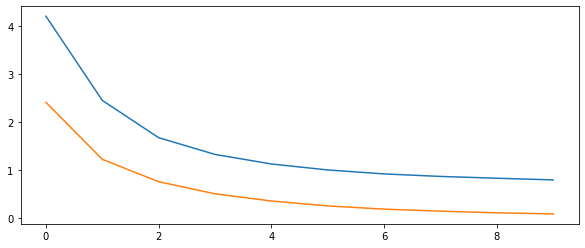

In [24]:
plt.figure(figsize = (10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [25]:
test_predictions = model.predict([x_test_s , x_test_n])

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
acc = accuracy_score(np.rint(test_predictions) , y_test)

In [29]:
acc

0.5220994475138122